# AFM Particle Detection and Average Particle Separation

http://pythonvision.org/basic-tutorial/<br>http://mahotas.readthedocs.io/en/latest/

In [1]:
import npia
#import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Convert image to grayscale
Code from "https://codedump.io/share/AbxxuPPXSXZQ/1/how-can-i-convert-an-rgb-image-into-grayscale-in-python"

## Import picture
update filename [par] and directory [cd] as needed

In [2]:
#dire="//Users/alex/backups/Particle Separation Analysis Photos"
#os.chdir(dire)
file='PtnanoCenk0.5et_171218_AM.0_00002_1.png'
scale_bar = 8
ub = 413.7
lb = -91.7
img=npia.Image(file,scale_bar=scale_bar, ub=ub, lb=lb)

## Show Image and Crop Scales
verify crop image shows entire picture 
if necessary adjust [ipx] and [ipy]

<class 'npia.core.Image'>


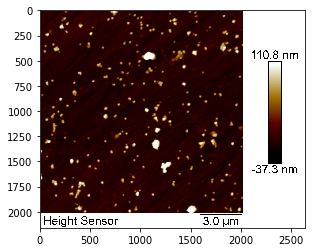

In [3]:
print(type(img))
imshow(img.image)

In [4]:
img.prepare()    #convert image from rgb to gray and crop

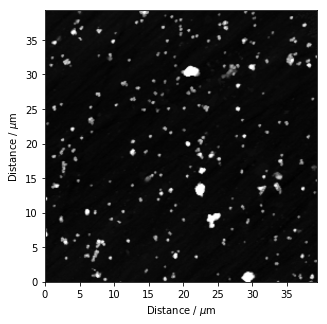

In [5]:
img.show_image('gray')

In [ ]:
img.prepare??


In [6]:
img.apply_threshold()

## Histogram analysis for Thresholding
verify that the calculated threshold is appropriate. This can have errors when the distribution is not bi modal

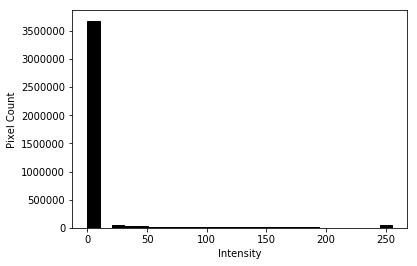

In [7]:
img.intensity_hist()

## Manual thresholding
In the case that there is multimodal data (>2)
If there are large particles (peak on histogram above at 255) can shrink data to maximum size of rest of data to remove effect on threshold [1st line]

move all backgroud data to 0 manually using [Ts1] from above histogram
Adjust 


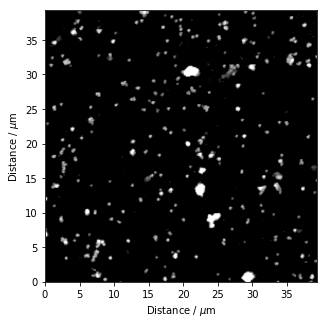

In [8]:
img.apply_gaussian_filter
img.show_image('gray')


### Graph a) Minimized peak heights for the large particles in an attempt to make a bimodal histogram

Graph b) Smoothed background removing smaller particles for a bimodal distribution

### Verification that the data is thresholded properly

Adjust the thresholded value if graph is not representative

[[ 925.87794476  929.86675209]
 [ 242.           70.        ]
 [ 375.         1826.25      ]
 [ 562.         1426.5       ]
 [ 614.49978768 1058.        ]
 [ 931.5        1473.5       ]
 [1300.4          85.8       ]
 [1709.          399.        ]
 [1966.5         391.5       ]
 [2012.          560.        ]]


AttributeError: 'Image' object has no attribute 'spots'

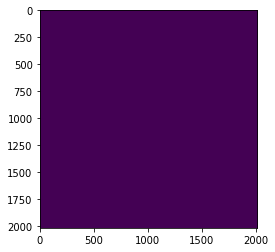

In [9]:
img.get_com(scan_filter=(3,3))
print(img.com)
imshow(img.spots)
img.show_image('Greys', overlay_com=img.com)

## Gaussian Fit to isolate particles
check Gaussian pixel fit to identify particles correctly. A good starting point is 8, with other common values (from experience) being 12,16,24,30

In [ ]:
gf=5  # gaussian pixel fit
pargcfs = mh.gaussian_filter(pargcfs, gf).astype('uint8')
Bc_ = np.ones((3,3))
rmaxg = mh.regmax(pargcfs,Bc=Bc_)

imshow(mh.overlay(pargcfs, rmaxg), extent=[0,pc*ipx,0,pc*ipy])
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()


figure()
imshow(rmaxg, extent=[0,pc*ipx,0,pc*ipy])
gray()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()



## Distance Transformation and watershed
reformating particles into spheres (distance transform) followed by inversion to set up watershed (particle identification and labeling)

may need to adjust Threshold value [Ta] and [thr] via dist.mean value

In [ ]:
spots,n_spots = mh.label(rmaxg)
print(n_spots)

Ta = 1*mh.thresholding.otsu(pargcfs,0)
h=hist(pargcfs.ravel(),bins=int(255/10),fc='k', ec='k')
xlabel('Intensity')
ylabel('Pixel Count')
show()
print(Ta)
dist = mh.distance(pargcfs > 0.05*Ta)   ###pargcfs

dist = dist.max() - dist#
dist -= dist.min()# inverting color
dist = dist/float(dist.ptp()) * 255
dist = dist.astype(np.uint8)
dist=mh.stretch(dist,0,255)
figure()
imshow(dist, extent=[0,pc*ipx,0,pc*ipy])
jet()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')


In [ ]:
print(type(areas))
np.unique(areas)

## Particle Distribution
Calculation of size and surface density calculation
Verify labeled areas correlate to above thresholded image 

In [ ]:
Bc1= np.ones((9,9))
seeds,n_seeds = mh.label(areas,Bc=Bc1)
#seeds=np.copy(spots)
#n_seeds=np.copy(n_spots)

sp=np.where(seeds)
imshow(seeds, extent=[0,pc*ipx,0,pc*ipy])
jet()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()

locg=mh.center_of_mass(pargc,seeds)       # location for each seed
locg=locg.astype(int)

sg = mh.labeled.labeled_size(seeds)
pr_mean=np.sqrt(mean(sg[1:])/np.pi)*pc   #average particle radius assuming circular shape
sg=np.sqrt(sg[1:]/np.pi)*pc              #particle radius assuming circular shape
pr_med=np.median(sg)
pr_std=np.sqrt(std(sg[1:])/np.pi)*pc
print('average particle radius: %1.4e +- %1.4e um'%(pr_mean,pr_std))
print('median particle radius: %1.4e +- %1.4e um'%(pr_med,pr_std))
print('number of particles: %.0f'%n_seeds)
#hist(seeds.ravel()):
figure()
hist(sg, bins=40)#,range=(0,10));
xlabel('Particle radius / um')
ylabel('Particle count')

## Particle Separation Analysis
Calculating the partilce separation
Normalization and pythagorean separation show extremely close calculation fo particle separation so that they are in agreement with one another. 

In [ ]:
xsg,ysg=rmaxg.shape
x=xsg*pc  #x image length    um
y=ysg*pc  #y image length    um
rho=n_seeds/(y*x)   #particle density
print('Particle density:',rho,'particles/um^2') #
xa=np.linspace(0,x,ipx)
ya=np.linspace(0,y,ipy)
rmaxp=np.where(rmaxg)

dmi=np.empty(len(locg[:,0])-1) #initialize empty array of minimum particle distance for each particle
d=np.empty([len(locg[:,0])-1,len(locg[:,0])-1])
da=np.empty(len(locg[:,0])-1)
a=0
#print(locg)
xloc=np.empty([1,2])
for s in range(0,len(locg[:,0])-1):
    dm=np.empty(len(locg[:,0])-1)   #distance between particle S and every other particle
    for ss in range(0,len(locg[:,0])-1):

        d[s,ss]=norm(locg[s,:]-locg[ss,:])
        dm[ss]=np.sqrt(np.square(xa[locg[s,0]]-xa[locg[ss,0]])+np.square(ya[locg[s,1]]-ya[locg[ss,1]]))

    dmi[s]=np.amin(dm[np.nonzero(dm)])
    da[s]=np.amin(d[s,np.nonzero(d[s,:])])
    if da[s]/sg[s]>3: #thresholded value
        xloc[a,[0,1]]=locg[s,:]
        xloc=np.pad(xloc,[0,2],'constant',constant_values=[0])
        a=a+1
#print(xloc)
l,w=np.shape(xloc)
mask=np.ones((l,w),dtype=bool)
mask[0:int((l+1)/2),2:w]=False
xloc=(np.reshape(xloc[mask,...],(-1,2)))
xloc=xloc[int(l/2),:]
print(xloc)
da_mean = np.mean(da)*pc
da_std = np.std(da)*pc
print('Average particle separation is: %1.4e +- %1.4e um'%(np.mean(dmi),np.std(dmi)))#%1.4e cm-3' % (Pb)
print('Average minimum particle norm is: %1.4e +- %1.4e um'%(da_mean,da_std))
matshow(d);
jet()



figure()
imshow(mh.overlay(pargc,xloc), extent=[0,pc*ipx,0,pc*ipy])               #3
gray()
xlabel('Distance / $\mu$m')
ylabel('Distance / $\mu$m')
show()


In [ ]:
spr=np.mean(dmi)/np.mean(sg)
print('separation-particle size ratio:',spr)


In [ ]:
ssx=pc*ipx
ssy=pc*ipy

### Pause before storing results and parameters

In [ ]:
input('Press enter to continue')

### Store results and parameters of results in one file

In [ ]:
df=pd.read_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis.csv")
dfp=pd.read_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis Parameters.csv")

df=df.append({'dir':dire,'file':file,'pr_mean':pr_mean,'pr_med':pr_med,'pr_std':pr_std,'da_mean':da_mean,'da_std':da_std,'rho':rho,'spr':spr,'ssx':ssx,'ssy':ssy,'n_seeds':n_seeds},ignore_index=True)
dfp=dfp.append({'dir':dire,'file':file,'Ti':Ti,'Ts1':Ts1,'Ts':Ts,'Tb':Tb,'gf':gf,'Ta':Ta,'thr':th},ignore_index=True)
print(df)
print(dfp)
df.to_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis.csv")
dfp.to_csv("/Users/alex/backups/Particle Separation Analysis Photos/Particle Analysis Parameters.csv")